# CLEAR AND PRECISE STEPS

# 1. Load and Explore the Dataset

In [5]:
import pandas as pd

# Load data
df = pd.read_csv(r"D:\Downloads\synthetic_customer_transactions.csv")

# Convert OrderDate to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Quick overview
print(df.head())
print(df.info())
print(df.describe())

  CustomerID OrderID  OrderDate  OrderAmount
0      C0103  O00001 2022-08-03        51.67
1      C0436  O00002 2023-09-24        40.54
2      C0349  O00003 2023-07-21        67.71
3      C0271  O00004 2022-01-27        85.04
4      C0107  O00005 2023-09-22        27.23
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   5000 non-null   object        
 1   OrderID      5000 non-null   object        
 2   OrderDate    5000 non-null   datetime64[ns]
 3   OrderAmount  5000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 156.4+ KB
None
                        OrderDate  OrderAmount
count                        5000  5000.000000
mean   2023-01-01 11:35:48.480000    96.522448
min           2022-01-01 00:00:00     0.010000
25%           2022-07-02 00:00:00    28.630000
50%           202

**Important to check**

- OrderDate is in datetime format
- No missing values in key columns: CustomerID, OrderID, OrderAmount, OrderDate

# 2. Feature Engineering (Recency, Frequency, AOV)

In [9]:
import datetime as dt

# Snapshot date = 1 day after the most recent order
snapshot_date = df['OrderDate'].max() + dt.timedelta(days=1)

In [11]:
# Group by customer and calculate RFM features
rfm = df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'OrderID': 'nunique',                                   # Frequency
    'OrderAmount': ['sum', 'mean']                          # Monetary (Total Spend), AOV
}).reset_index()

In [13]:
# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AOV']

**We have a customer-level dataset ready for modeling**

#  3. Model Building

In [19]:
# predicting Monetary (Total Spend) as proxy for LTV.

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [21]:
# Features and target
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Monetary']

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Predictions
y_pred = rf_model.predict(X_test)

In [32]:
# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 35.98
RMSE: 89.33


# 4. Predict and Segment Customers

In [35]:
# Predict LTV using trained Random Forest model
rfm['Predicted_LTV'] = rf_model.predict(X)

# Segment customers
def segment(ltv):
    if ltv >= rfm['Predicted_LTV'].quantile(0.75):
        return 'High Value'
    elif ltv >= rfm['Predicted_LTV'].quantile(0.50):
        return 'Mid Value'
    else:
        return 'Low Value'

rfm['Segment'] = rfm['Predicted_LTV'].apply(segment)

# 5. Save the results

In [40]:
rfm.to_csv("final_ltv_predictions.csv", index=False)

# 6. Visualization

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

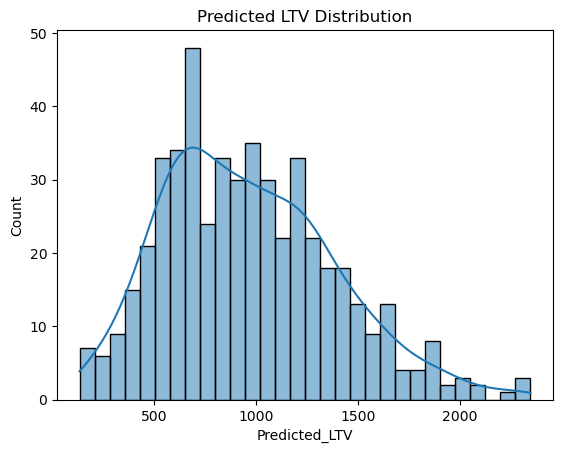

In [45]:
# Distribution of Predicted LTV
sns.histplot(rfm['Predicted_LTV'], bins=30, kde=True)
plt.title("Predicted LTV Distribution")
plt.show()

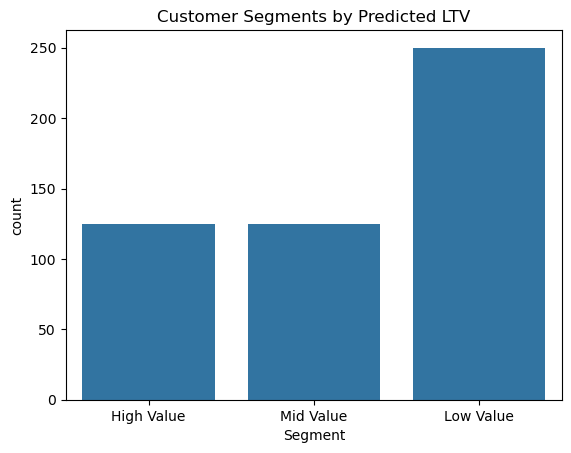

In [47]:
# Segment counts
sns.countplot(data=rfm, x='Segment', order=['High Value', 'Mid Value', 'Low Value'])
plt.title("Customer Segments by Predicted LTV")
plt.show()

# ALL TOGETHER STEPS

**It demonstrates the end-to-end pipeline for predicting customer lifetime value model using purchase behaviour**

# 1. Importing Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime as dt

# 2. Loading Dataset

In [65]:
df = pd.read_csv(r"D:\Downloads\synthetic_customer_transactions.csv")
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df.head()

,CustomerID,OrderID,OrderDate,OrderAmount
0,C0103,O00001,2022-08-03,51.67
1,C0436,O00002,2023-09-24,40.54
2,C0349,O00003,2023-07-21,67.71
3,C0271,O00004,2022-01-27,85.04
4,C0107,O00005,2023-09-22,27.23


# 3. Feature Engineering

In [68]:
# Snapshot date is 1 day after the most recent order
snapshot_date = df['OrderDate'].max() + dt.timedelta(days=1)

# Calculate RFM features
rfm = df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (snapshot_date - x.max()).days,
    'OrderID': 'nunique',
    'OrderAmount': ['sum', 'mean']
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AOV']
rfm.head()

,CustomerID,Recency,Frequency,Monetary,AOV
0,C0001,67,14,865.91,61.850714
1,C0002,8,10,1445.05,144.505000
2,C0003,223,9,467.40,51.933333
3,C0004,49,10,421.23,42.123000
4,C0005,11,15,1654.47,110.298000


# 4. Model Building

In [71]:
# Train/Test split
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Monetary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 35.98
RMSE: 89.33


# 5. Predict and Segment Customers

In [74]:
# Predict LTV for all customers
rfm['Predicted_LTV'] = rf_model.predict(X)

# Segment customers
def segment(ltv):
    if ltv >= rfm['Predicted_LTV'].quantile(0.75):
        return 'High Value'
    elif ltv >= rfm['Predicted_LTV'].quantile(0.50):
        return 'Mid Value'
    else:
        return 'Low Value'

rfm['Segment'] = rfm['Predicted_LTV'].apply(segment)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,AOV,Predicted_LTV,Segment
0,C0001,67,14,865.91,61.850714,864.6842,Low Value
1,C0002,8,10,1445.05,144.505000,1451.6758,High Value
2,C0003,223,9,467.40,51.933333,441.0579,Low Value
3,C0004,49,10,421.23,42.123000,451.5268,Low Value
4,C0005,11,15,1654.47,110.298000,1619.5894,High Value


# 6. Save the results

In [77]:
# Save the final predictions
rfm.to_csv('final_ltv_predictions.csv', index=False)

# 7. Visualization

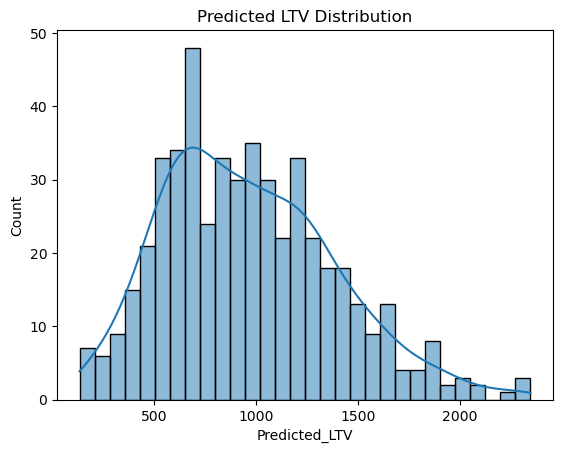

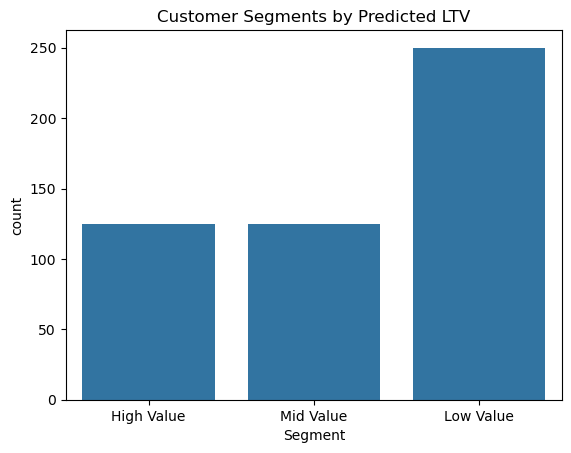

In [80]:
# Visualize predicted LTV distribution
sns.histplot(rfm['Predicted_LTV'], bins=30, kde=True)
plt.title('Predicted LTV Distribution')
plt.show()

# Segment distribution
sns.countplot(data=rfm, x='Segment', order=['High Value', 'Mid Value', 'Low Value'])
plt.title('Customer Segments by Predicted LTV')
plt.show()

# CONCLUSION

In this project, we developed a machine learning pipeline to predict Customer Lifetime Value (LTV) based on historical transaction data. By engineering key features such as Recency, Frequency, and Average Order Value (AOV), we trained a Random Forest Regressor to estimate the total monetary value a customer is likely to contribute over time.

Key outcomes:
- Model Performance was evaluated using MAE and RMSE, providing a reasonable estimate of prediction accuracy.
- Customer Segmentation was performed using the predicted LTV values, enabling the business to classify customers into High, Mid, and Low value segments.
- The final results were saved in a CSV format, which can be used by the marketing or CRM team for targeted campaigns and retention strategies.

This model provides a scalable and data-driven foundation for personalizing marketing efforts, optimizing resource allocation, and improving customer engagement strategies.

